In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, TimeSeriesSplit
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from datetime import datetime, timedelta
from collections import defaultdict

In [194]:
# Hardcoding ticker symbols for top 100 market cap stocks. 
# Comments: I couldn't find an effective way to query yfinance for tickers.
# I also tried using URL links, but they did not work, so I implemented the list of tickers manually. 
data = [
    "AAPL", "NVDA", "MSFT", "TXGE", "AMZN", "GOOG", "GOOGL", "META",
    "TSLA", "TSM", "BRK-B", "BRK-A", "JPM", "AVGO", "WMT", "LLY", "V", "UNH",
    "ORCL", "XOM", "MA", "NVO", "TCTZF", "TCEHY", "NONOF", "BAC", "COST",
    "HD", "PG", "NFLX", "JNJ", "CRM", "JPM-PD", "JPM-PC", "BML-PL", "BML-PH",
    "BML-PG", "LVMHF", "BAC-PE", "LVMUY", "ABBV", "BAC-PK", "BAC-PL", "SAPGF",
    "SAP", "RCIT", "ASMLF", "IDCBY", "ASML", "CVX", "TMUS", "IDCBF", "GDVTZ",
    "KO", "MRK", "BML-PJ", "BAC-PB", "ACGBF", "WFC", "HESAF", "HESAY", "CSCO",
    "ADBE", "RHHVF", "AMD", "ACGBY", "RHHBY", "NOW", "TOYOF", "TM", "MS",
    "RHHBF", "GS", "BX", "ACN", "NSRGY", "NSRGF", "NVSEF", "PEP", "LIN", "IBM",
    "AXP", "DIS", "MCD", "AZNCF", "AZN", "RYDAF", "NVS", "BABA", "PM", "PCCYF",
    "TMO", "ABT", "WFC-PY", "CICHY", "GE", "SHEL", "ISRG", "CAT", "TM"
]

# Storing stock data as a list of dictionaries
# Each dictionary contains a ticker symbol, company name, market cap, PE ratio, sector, and industry
# After the query, I convert stock_data into a pandas data frame for efficient access
stock_data = [{
    "Ticker": ticker,
    "Name": yf.Ticker(ticker).info.get("longName", "N/A"),
    "Market Cap": yf.Ticker(ticker).info.get("marketCap", "N/A"),
    "PE Ratio": yf.Ticker(ticker).info.get("trailingPE", "N/A"),
    "Sector": yf.Ticker(ticker).info.get("sector", "N/A"),
    "Industry": yf.Ticker(ticker).info.get("industry", "N/A")
} for ticker in data] 
stock_data = pd.DataFrame(stock_data)

# Error debugging is used to ensure the market cap is evaluated properly
# '< not supported between instances of int and str'
# Converting market cap strings into ints or floats
stock_data['Market Cap'] = pd.to_numeric(stock_data['Market Cap'], errors='coerce')
# Filterring out rows where market cap = NaN
stock_data = stock_data.dropna(subset=['Market Cap'])
# Sort the DataFrame by market cap in descending order
stock_data = stock_data.sort_values(by="Market Cap", ascending=False)
# Displaying sorted stock_data
print(stock_data)

   Ticker                             Name    Market Cap   PE Ratio  \
0    AAPL                       Apple Inc.  3.725894e+12   40.47455   
1    NVDA               NVIDIA Corporation  3.411702e+12   54.84646   
3    TXGE  Texas Gulf Energy, Incorporated  3.351351e+12        N/A   
2    MSFT            Microsoft Corporation  3.338187e+12   37.04538   
4    AMZN                 Amazon.com, Inc.  2.421184e+12   49.30621   
..    ...                              ...           ...        ...   
86  RYDAF                        Shell plc  1.961560e+11  12.959349   
97   ISRG         Intuitive Surgical, Inc.  1.936189e+11   87.67742   
98    CAT                 Caterpillar Inc.  1.877472e+11  18.053389   
72     GS    The Goldman Sachs Group, Inc.  1.860105e+11   17.36185   
95     GE                     GE Aerospace  1.825174e+11   33.19685   

                Sector                             Industry  
0           Technology                 Consumer Electronics  
1           Technology 

In [195]:
# get_prices function to return adj close prices for a list of tickers and a date range.
# Outputs: prices (pd.DataFrame)
# Inputs: tickers (array), start_date (str), end_date (str)
def get_prices(tickers, start_date, end_date):
    prices = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return prices
    
# Initialization of input variables
# Using 2020-09-01 (after pandemic shutdowns ended) as start_date
# Using a year before today as end_date
# In-Sample range: 2020/09/01 - a year before today (dynamically calculated)
# Out-Of-Sample range: a year before today - today
start_date = '2020-09-01'
end_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
start_date_outsamp = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
end_date_outsamp = datetime.today()

prices = get_prices(data, start_date, end_date)
prices_outsamp = get_prices(data, start_date_outsamp, end_date_outsamp)

# I dropped the GTOFF column due to lack of data in yfinance. 
# There are only NaN values or price = 0.0109, which isn't accurate. 
# I decided to replace GTOFF with the 101st largest stock by market cap. 
# In this case, it is TM. I added TM to our data array. 
# Replace NaN values with the mean of their respective columns.
# Some stocks do not have prices for a particular date in yfinance.
# I decided to replace NaN values with the means of their respective price columns. 
if prices.isna().any().any():
    print("\nReplacing NaN values with the mean of their respective columns.")
    prices = prices.apply(lambda x: x.fillna(x.mean()), axis=0)

# Updated prices DataFrame
print("\nUpdated prices DataFrame:")
print(prices.head())

prices.to_csv("top100stocks_marketcap_prices_csv_is.csv", index=True)
prices_outsamp.to_csv("top100stocks_marketcap_prices_csv_oos.csv", index=True)

[*********************100%***********************]  99 of 99 completed
[*********************100%***********************]  99 of 99 completed



Replacing NaN values with the mean of their respective columns.

Updated prices DataFrame:
Ticker                           AAPL       ABBV         ABT     ACGBF  \
Date                                                                     
2020-09-01 00:00:00+00:00  130.982620  77.500946   98.863457  0.237902   
2020-09-02 00:00:00+00:00  128.268829  78.937714  101.544983  0.230693   
2020-09-03 00:00:00+00:00  117.999535  77.190086   97.917038  0.237902   
2020-09-04 00:00:00+00:00  118.077621  77.190086   96.645882  0.223484   
2020-09-08 00:00:00+00:00  110.131592  75.803734   95.421104  0.223484   

Ticker                        ACGBY         ACN        ADBE        AMD  \
Date                                                                     
2020-09-01 00:00:00+00:00  5.845712  225.713974  527.950012  92.180000   
2020-09-02 00:00:00+00:00  5.824115  232.447205  533.799988  90.220001   
2020-09-03 00:00:00+00:00  5.788119  224.735977  507.799988  82.540001   
2020-09-04 00:00:00

In [196]:
# compute_correlations function to return highly correlated pairs (above a certain threshold). 
# Outputs: correlated_pairs (list of tuples)
# Inputs: prices (pd.DataFrame), stock_data (pd.DataFrame), threshold (float)
def compute_correlations(prices, stock_data, threshold=0.9):
    # Initialization of pairs list
    correlated_pairs = []
    # Storage of price columns 
    columns = prices.columns
    num_columns = len(columns)
    # Standardizing prices for more accurate correlation calculaton
    standardized_prices = (prices - prices.mean()) / prices.std()

    # Creating mapping from tickers to company names
    # The purpose of this is to identify and exclude pairs of stocks belonging to the same company
    # For example, GOOG (no voting rights) & GOOGL (one vote per share) are derived from Alphabet Inc. 
    # If abs(correlation(GOOG vs. stock_2)) > abs(correlation(GOOGL vs. stock_2)), we keep GOOG. 
    ticker_to_company = dict(zip(stock_data["Ticker"], stock_data["Name"]))
    excluded_tickers = set()
    
    # Iterate over pairs of stocks
    for i in range(num_columns):
        # Only process upper triangle to avoid redundancy
        for j in range(i + 1, num_columns):  
            stock1 = columns[i]
            stock2 = columns[j]
            
            # Skip if either stock has already been excluded
            if stock1 in excluded_tickers or stock2 in excluded_tickers:
                continue
                
            # Check if both tickers belong to the same company
            if ticker_to_company.get(stock1) == ticker_to_company.get(stock2):
                # Compare correlations for the stock pair and decide on the exclusion
                corr_stock1 = standardized_prices[stock1].corr(standardized_prices[stock2])
                corr_stock2 = standardized_prices[stock2].corr(standardized_prices[stock1])
                if abs(corr_stock1) > abs(corr_stock2):
                    excluded_tickers.add(stock2)  
                else:
                    excluded_tickers.add(stock1) 
                continue  

            # Compute correlation for stock pair
            corr = standardized_prices[stock1].corr(standardized_prices[stock2])

            # Filter for highly correlated pairs (above threshold = 0.95)
            # Storing correlation statistics as tuples
            # Tuples contain: stock_1 (str), stock_2 (str), correlation (float)
            if abs(corr) > threshold:
                correlated_pairs.append((stock1, stock2, corr))

    return correlated_pairs


# Compute correlations and store as list of tuples
high_correlation_pairs = compute_correlations(prices, stock_data, threshold=0.95)

# Convert results into DataFrame
# Columns: Stock_1, Stock_2, Correlation = abs(correlation)
highly_correlated_df = pd.DataFrame(high_correlation_pairs, columns=["Stock_1", "Stock_2", "Correlation"])

# Positive correlations (> 0)
non_negative_df = highly_correlated_df[highly_correlated_df["Correlation"] >= 0].sort_values(
    by="Correlation", ascending=False
)

# Negative correlations (< 0)
negative_df = highly_correlated_df[highly_correlated_df["Correlation"] < 0].sort_values(
    by="Correlation", ascending=True 
)

# Displaying results
print("Non-Negative Correlations (Sorted):")
print(non_negative_df)
print("\nNegative Correlations (Sorted):")
print(negative_df)

Non-Negative Correlations (Sorted):
  Stock_1 Stock_2  Correlation
4     LLY     NVO     0.964510
2     CVX     XOM     0.964260
3     LLY   NONOF     0.963255
0    ABBV     CVX     0.958597
6    SHEL     XOM     0.957070
5     NVO   PCCYF     0.956256

Negative Correlations (Sorted):
  Stock_1 Stock_2  Correlation
1    BABA     UNH    -0.951109


In [197]:
# scale_prices function to return scaled_prices DataFrame, along with scaler. 
# Outputs: scaled_prices_df, scaler
# Inputs: prices, stock pair
def scale_prices(prices_df, pair):
    # Scale stock prices for consistency
    scaler = StandardScaler()
    stock_prices = prices_df[list(pair)].dropna()
    scaled_data = scaler.fit_transform(stock_prices)
    scaled_prices_df = pd.DataFrame(scaled_data, columns=pair)
    return scaled_prices_df, scaler

# run_ols_regression function to perform OLS regression on a given stock pair and evaluate its performance.
# Outputs: Dictionary of OLS results (if model meets quality thresholds) or None
# Inputs:
# - pair (tuple): A tuple containing the two stock tickers (stock1, stock2).
# - scaled_prices_df (pd.DataFrame)
def run_ols_regression(pair, scaled_prices_df):
    stock1, stock2 = pair
    # Independent variable (X) is the scaled price of stock1 with a constant term added
    # Dependent variable (y) is the scaled price of stock2
    X = sm.add_constant(scaled_prices_df[stock1].values)
    y = scaled_prices_df[stock2].values
    #Split data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    #Train OLS model
    #Citations: Utilized ChatGPT for more context on cov_type and why to use it here. 
    ols_model = sm.OLS(y_train, X_train).fit(cov_type='HC3')

    #Predictions and metrics
    y_train_pred = ols_model.predict(X_train)
    y_test_pred = ols_model.predict(X_test)
    mse_train = mean_squared_error(y_train, y_train_pred)
    mse_test = mean_squared_error(y_test, y_test_pred)

    # Return OLS results: adjusted R-squared, p-value, F-statistic, coefficient, and MSE
    # Filter results based on model quality: adj_r2 >= 0.9 and test MSE <= 0.1
    adj_r2 = ols_model.rsquared_adj
    if adj_r2 >= 0.9 and mse_test <= 0.1:
        return {
            'pair': pair,  
            'ols_model': ols_model, 
            'train_r2': ols_model.rsquared,  
            'test_r2': 1 - (mse_test / mean_squared_error(y_test, [y_test.mean()] * len(y_test))), 
            'adj_r2': adj_r2,  
            'p_value': ols_model.pvalues[1],  
            'f_statistic': ols_model.fvalue,  
            'coefficient': ols_model.params[1], 
            'summary': ols_model.summary(),  
            'mse_train': mse_train, 
            'mse_test': mse_test,  
            'scaler': scaler  
        }
    return None

# Initialize lists to store OLS results
ols_results = [] 
filtered_results = []

# Iterate through the highly correlated pairs to run OLS regression
for _, row in highly_correlated_df.iterrows():
    stock1, stock2 = row['Stock_1'], row['Stock_2'] 
    # Price scaling
    scaled_prices_df, scaler = scale_prices(prices, (stock1, stock2))
    # OLS regression for the current pair
    result = run_ols_regression((stock1, stock2), scaled_prices_df)
    
    # Appending results to ols_results and filtered_results
    if result is not None:
        ols_results.append(result)
        filtered_results.append(result)

# Summary of OLS results
# Citations: Utilized ChatGPT for efficient printing structure. 
print("OLS Regression Results:")
for result in ols_results:
    print("Pair:", result['pair'], 
          "Adj R^2:", round(result['adj_r2'], 4), 
          "Test MSE:", round(result['mse_test'], 4), 
          "Coefficient:", round(result['coefficient'], 4), 
          "P-value:", round(result['p_value'], 4), 
          "F-statistic:", round(result['f_statistic'], 4))
    print("-" * 70)

OLS Regression Results:
Pair: ('ABBV', 'CVX') Adj R^2: 0.9216 Test MSE: 0.0894 Coefficient: 0.9521 P-value: 0.0 F-statistic: 10437.0574
----------------------------------------------------------------------
Pair: ('CVX', 'XOM') Adj R^2: 0.9283 Test MSE: 0.0693 Coefficient: 0.9607 P-value: 0.0 F-statistic: 10527.1343
----------------------------------------------------------------------
Pair: ('LLY', 'NONOF') Adj R^2: 0.9246 Test MSE: 0.0695 Coefficient: 0.968 P-value: 0.0 F-statistic: 16973.3174
----------------------------------------------------------------------
Pair: ('LLY', 'NVO') Adj R^2: 0.927 Test MSE: 0.067 Coefficient: 0.9686 P-value: 0.0 F-statistic: 17454.2231
----------------------------------------------------------------------
Pair: ('NVO', 'PCCYF') Adj R^2: 0.9115 Test MSE: 0.0833 Coefficient: 0.958 P-value: 0.0 F-statistic: 3810.8623
----------------------------------------------------------------------
Pair: ('SHEL', 'XOM') Adj R^2: 0.9169 Test MSE: 0.0894 Coefficient

In [198]:
# Citations: Utilized ChatGPT for assistance with polynomial regression structure and implementation. 
# Also, I utilized ChatGPT to help with printing structure and filtering out results that don't match our criteria for R_sq and test_mse. 

# run_polynomial_regression function to perform polynomial regression on a given stock pair and evaluate its performance
# Outputs: Dictionary of regression results (if the model meets quality thresholds) or None
# Inputs: 
# - pair (tuple): A tuple containing the two stock tickers (stock1, stock2)
# - scaled_prices_df (pd.DataFrame): Scaled stock prices
# - degrees (list): List of polynomial degrees to test (default is [2, 3])
def run_polynomial_regression(pair, scaled_prices_df, degrees=[2, 3]):
    stock1, stock2 = pair
    # Prepare independent (X) and dependent (y) variables using scaled data
    X = scaled_prices_df[stock1].values.reshape(-1, 1)
    y = scaled_prices_df[stock2].values
    # Split the data into training and test sets
    # Decided on 70-30 split due to the importance of the test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Initialize variables to store the best model's metrics
    best_adj_r2 = -float('inf')
    best_degree = None
    best_model = None
    best_mse_test = float('inf')
    best_model_stats = None

    # Iterate through the polynomial degrees
    for degree in degrees:
        # Polynomial features for the current degree
        poly = PolynomialFeatures(degree=degree)
        X_poly_train = poly.fit_transform(X_train)
        X_poly_test = poly.transform(X_test)
        # Fitting polynomial regression model
        poly_model = LinearRegression()
        poly_model.fit(X_poly_train, y_train)
        # Predict on training and test sets
        y_train_pred = poly_model.predict(X_poly_train)
        y_test_pred = poly_model.predict(X_poly_test)
        # Calculate mean squared errors (MSE) for training and test sets
        mse_train = mean_squared_error(y_train, y_train_pred)
        mse_test = mean_squared_error(y_test, y_test_pred)
        # Calculate adjusted R-squared for the test set
        r_squared_test = poly_model.score(X_poly_test, y_test)
        n, p = len(y_train), X_poly_train.shape[1]
        adj_r2 = 1 - (1 - r_squared_test) * (n - 1) / (n - p - 1)
        # Fit the model using statsmodels for p-values
        X_poly_train_sm = sm.add_constant(X_poly_train)
        sm_model = sm.OLS(y_train, X_poly_train_sm).fit()

        # Update the best model if it outperforms existing model
        # i.e -> if third degree polynomial performs better than second degree
        if adj_r2 > best_adj_r2 and mse_test < best_mse_test:
            best_adj_r2 = adj_r2
            best_degree = degree
            best_model = poly_model
            best_mse_test = mse_test
            best_model_stats = sm_model

    # Returns best model's results if it meets numerical thresholds
    # adj_r2, test_mse, and p-values are all satisfactory
    if best_adj_r2 >= 0.9 and best_mse_test <= 0.1 and all(p < 0.05 for p in best_model_stats.pvalues):
        coefficients = best_model.coef_
        intercept = best_model.intercept_
        # Model equation as a string
        # Citations: Utilied ChatGPT to construct model_equation with fstring formatting for future reference
        model_equation = f"y = {intercept:.4f} " + " ".join([f"+ {coeff:.4f}x^{i}" for i, coeff in enumerate(coefficients) if i > 0])
        p_values = best_model_stats.pvalues
        return {
            'pair': pair,
            'adj_r2': best_adj_r2,
            'mse_train': mse_train,
            'mse_test': best_mse_test,
            'coefficients': coefficients,
            'intercept': intercept,
            'best_degree': best_degree,
            'poly_model': best_model,
            'model_equation': model_equation,
            'p_values': p_values
        }
    return None

poly_results = []
# Iterate through filtered results for regression analysis
for result in filtered_results:
    stock1, stock2 = result['pair'] 
    scaled_prices_df, scaler = scale_prices(prices, (stock1, stock2))
    # Polynomial regression on the scaled data
    poly_result = run_polynomial_regression((stock1, stock2), scaled_prices_df)
    # Append results to poly_results
    if poly_result is not None:
        poly_results.append(poly_result)
        # Citations: Utilized ChatGPT for proper usage of idx and enumerate in the for loop below
        for idx, filtered_result in enumerate(filtered_results):
            # Replace OLS results with polynomial results if polynomial model shows improvement
            if filtered_result['pair'] == poly_result['pair']:
                if poly_result['adj_r2'] > 1.025 * filtered_result['adj_r2'] and poly_result['mse_test'] < 0.975 * filtered_result['mse_test']:
                    filtered_results[idx] = poly_result
                break

# Display filtered results
# Citations: Utilised ChatGPT to print regression results efficiently 
print("\nFiltered Results:")
for result in filtered_results:
    if 'poly_model' in result:
        # Display results for polynomial models
        print("[Poly] Pair:", result['pair'], 
              "Degree:", result['best_degree'], 
              "Adj R^2:", round(result['adj_r2'], 4), 
              "Test MSE:", round(result['mse_test'], 4))
        print("Model Equation:", result['model_equation'])
        print("P-values:", result['p_values'])
    else:
        # Display results for OLS models
        print("[OLS] Pair:", result['pair'], 
              "Adj R^2:", round(result['adj_r2'], 4), 
              "Test MSE:", round(result['mse_test'], 4), 
              "Coefficient:", round(result['coefficient'], 4), 
              "P-value:", round(result['p_value'], 4), 
              "F-statistic:", round(result['f_statistic'], 4))
    print("-" * 70)


Filtered Results:
[OLS] Pair: ('ABBV', 'CVX') Adj R^2: 0.9216 Test MSE: 0.0894 Coefficient: 0.9521 P-value: 0.0 F-statistic: 10437.0574
----------------------------------------------------------------------
[OLS] Pair: ('CVX', 'XOM') Adj R^2: 0.9283 Test MSE: 0.0693 Coefficient: 0.9607 P-value: 0.0 F-statistic: 10527.1343
----------------------------------------------------------------------
[OLS] Pair: ('LLY', 'NONOF') Adj R^2: 0.9246 Test MSE: 0.0695 Coefficient: 0.968 P-value: 0.0 F-statistic: 16973.3174
----------------------------------------------------------------------
[OLS] Pair: ('LLY', 'NVO') Adj R^2: 0.927 Test MSE: 0.067 Coefficient: 0.9686 P-value: 0.0 F-statistic: 17454.2231
----------------------------------------------------------------------
[OLS] Pair: ('NVO', 'PCCYF') Adj R^2: 0.9115 Test MSE: 0.0833 Coefficient: 0.958 P-value: 0.0 F-statistic: 3810.8623
----------------------------------------------------------------------
[Poly] Pair: ('SHEL', 'XOM') Degree: 3 Ad

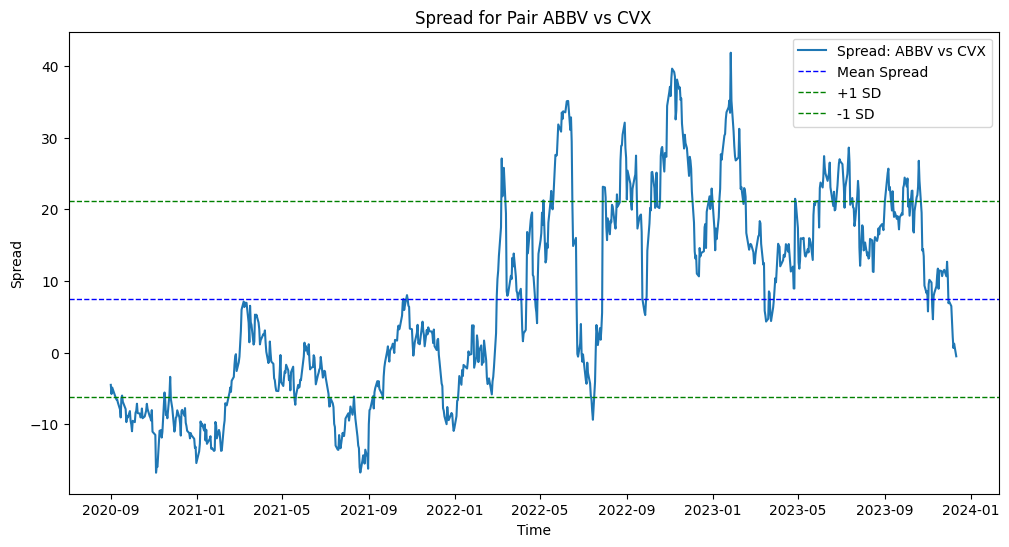

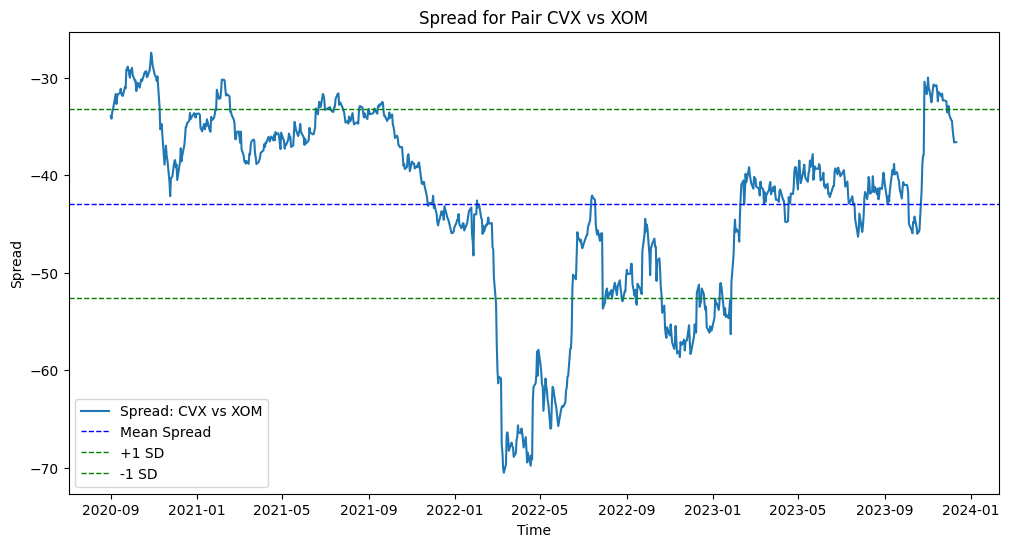

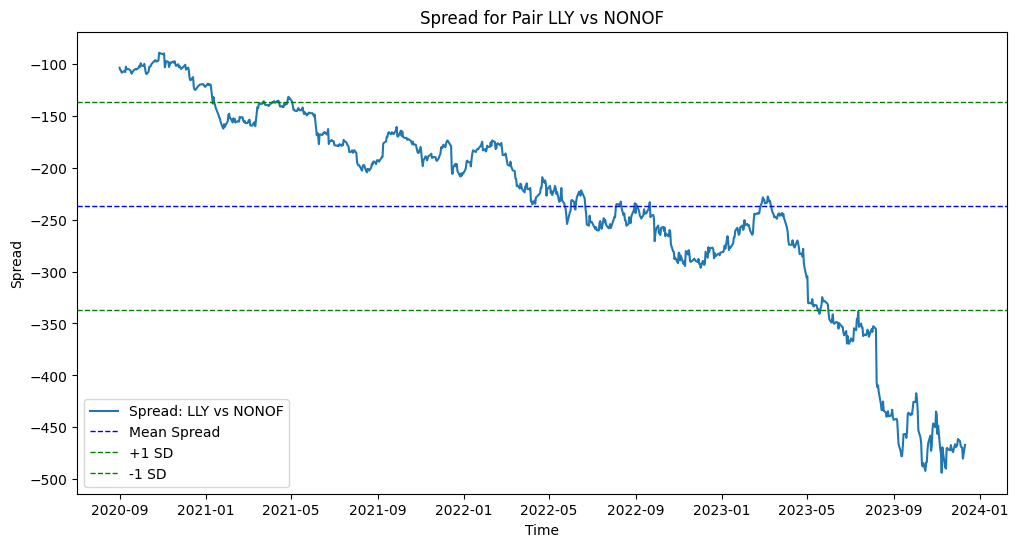

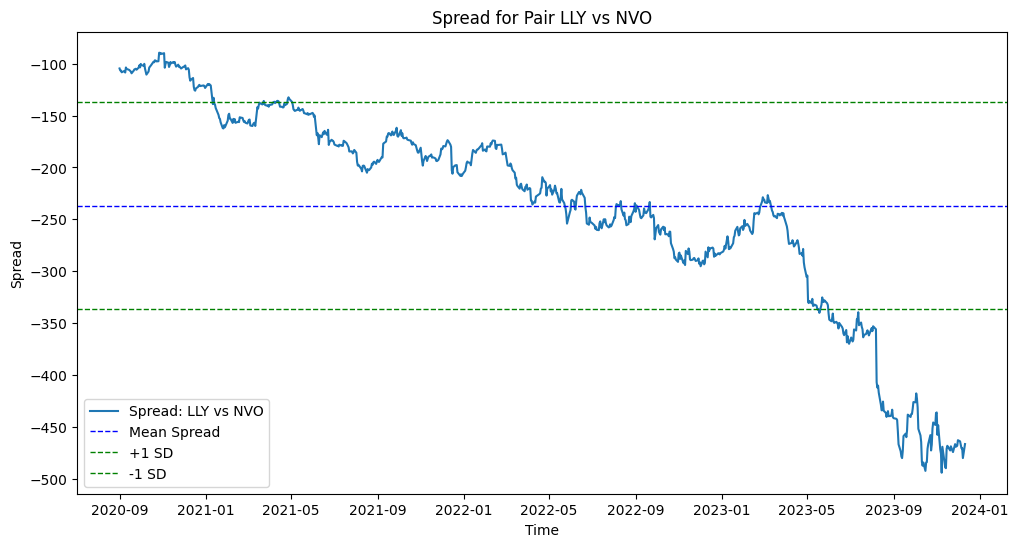

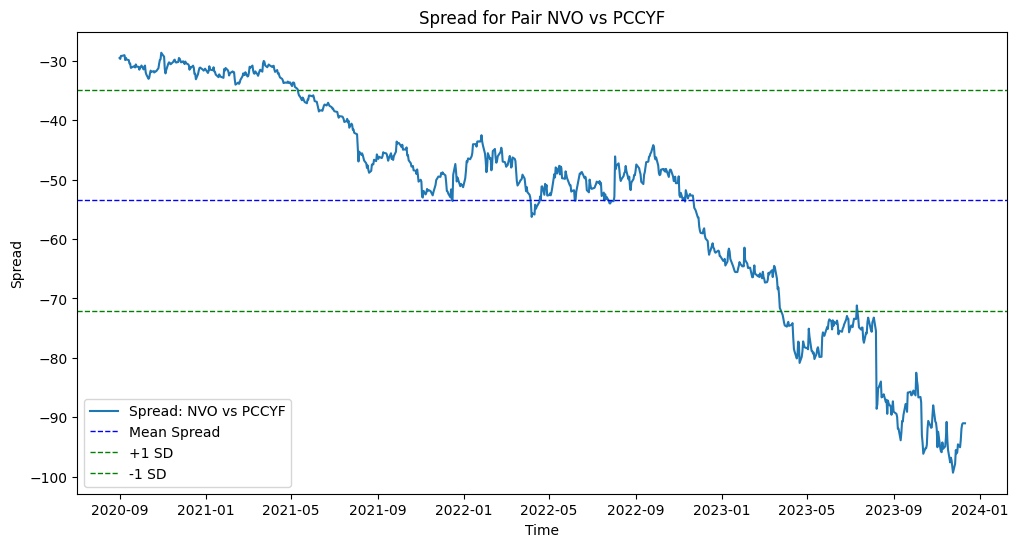

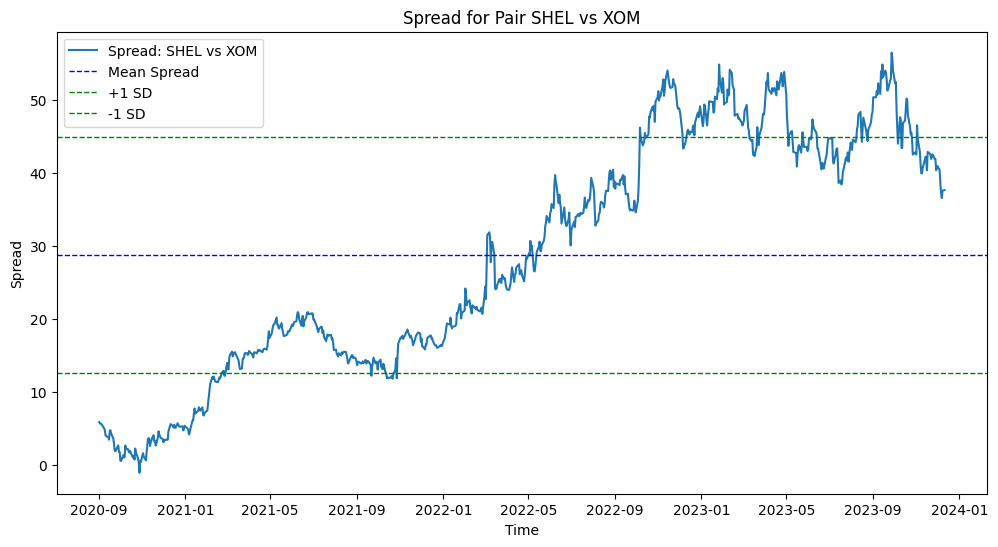

In [199]:
# calculate_spread_using_ols function to calculate the spread between two stocks using an OLS model
# Outputs: spread 
# Inputs:
# - stock1_prices
# - stock2_prices
# - ols_model (statsmodels OLS)
# Updated function to calculate the spread using an OLS model
# Citations: Utilized ChatGPT to debug errors when building calculate spread functions
def calculate_spread_using_ols(stock1_prices_sample, stock2_prices_sample, ols_model):
    # Extract intercept and beta from the OLS model
    intercept = ols_model.params[0]  
    beta = ols_model.params[1] 
    # Calculate the spread using the formula: Spread = Stock 2 - (Intercept + Beta * Stock 1)
    spread = stock2_prices_sample - (intercept + beta * stock1_prices_sample)
    return spread

# Updated function to calculate the spread between two stocks using a polynomial regression model
def calculate_spread_using_poly(stock1_prices_sample, stock2_prices_sample, poly_model, degree):
    # Scaling stock1_prices_sample to ensure consistency of scaling throughout
    scaler = StandardScaler()
    stock1_prices_scaled = scaler.fit_transform(stock1_prices_sample.values.reshape(-1, 1)).flatten()
    # Polynomial features for scaled stock1_prices_sample
    poly = PolynomialFeatures(degree=degree)
    X_poly_scaled = poly.fit_transform(stock1_prices_scaled.reshape(-1, 1))
    # Calculate polynomial model's coefficients and intercept for predictions
    coefficients = poly_model.coef_
    intercept = poly_model.intercept_
    predicted_stock2_prices_scaled = intercept
    # Use formula for polynomial model equation
    # y = b_0 + b_1 * x_1 + b_2 * (x_2)^2 + b_3 * (x_3)^3
    for i in range(1, degree + 1):
        predicted_stock2_prices_scaled += coefficients[i] * X_poly_scaled[:, i]
    # Inverse transform predicted stock2 prices to the original scale
    predicted_stock2_prices = scaler.inverse_transform(
        predicted_stock2_prices_scaled.reshape(-1, 1)
    ).flatten()
    # Spread = Stock2 - Predicted Stock2
    spread = stock2_prices_sample - predicted_stock2_prices
    return spread


# Iterate through filtered results to calculate and store spreads
for result in filtered_results:
    # Extract stock pair from the result
    stock1, stock2 = result['pair']
    stock1_prices = prices[stock1]
    stock2_prices = prices[stock2]

    if 'ols_model' in result:  
        # Calculate spread using OLS model
        spread = calculate_spread_using_ols(stock1_prices, stock2_prices, result['ols_model'])
        spread_mean = spread.mean() 
        spread_std = spread.std() 

        # Plotting spread for the OLS model
        # Citations: Utilized ChatGPT for efficient plotting structure and for loop structure
        plt.figure(figsize=(12, 6))
        plt.plot(spread, label="Spread: " + stock1 + " vs " + stock2)
        plt.axhline(spread_mean, color='blue', linestyle='--', linewidth=1, label='Mean Spread')
        plt.axhline(spread_mean + spread_std, color='green', linestyle='--', linewidth=1, label='+1 SD')
        plt.axhline(spread_mean - spread_std, color='green', linestyle='--', linewidth=1, label='-1 SD')
        plt.title("Spread for Pair " + stock1 + " vs " + stock2)
        plt.xlabel("Time")
        plt.ylabel("Spread")
        plt.legend()
        plt.show()

    elif 'poly_model' in result: 
        # Calculate spread using Polynomial model
        spread = calculate_spread_using_poly(stock1_prices, stock2_prices, result['poly_model'], degree=result['best_degree'])
        spread_mean = spread.mean() 
        spread_std = spread.std() 

        # Plotting spread for the Polynomial model
        # Citations: Utilized ChatGPT for efficient plotting structure and for loop structure
        plt.figure(figsize=(12, 6))
        plt.plot(spread, label="Spread: " + stock1 + " vs " + stock2)
        plt.axhline(spread_mean, color='blue', linestyle='--', linewidth=1, label='Mean Spread')
        plt.axhline(spread_mean + spread_std, color='green', linestyle='--', linewidth=1, label='+1 SD')
        plt.axhline(spread_mean - spread_std, color='green', linestyle='--', linewidth=1, label='-1 SD')
        plt.title("Spread for Pair " + stock1 + " vs " + stock2)
        plt.xlabel("Time")
        plt.ylabel("Spread")
        plt.legend()
        plt.show()

In [200]:
# mean_reverting_strategy function to return list of tuples, containing (action, price, date)
# Outputs: buy_sell_profits (list of tuples)
# Inputs:
# - stock1_name
# - stock2_name
# - spread_sample
# - stock1_prices
# - stock2_prices
# Citations: Utilized ChatGPT to debug errors when building this function
def mean_reverting_strategy(stock1_name, stock2_name, spread_sample, stock1_prices, stock2_prices):
    # Calculate the mean and standard deviation of the spread
    spread_mean = spread_sample.mean()
    spread_std = spread_sample.std()

    # Generate buy/sell/exit signals
    buy_signal = spread_sample < spread_mean - spread_std
    sell_signal = spread_sample > spread_mean + spread_std
    exit_signal = (spread_sample >= spread_mean - spread_std) & (spread_sample <= spread_mean + spread_std)

    # Portfolio: tracks the number of Stock1 and Stock2 held
    portfolio = {'stock1': 0, 'stock2': 0}
    buy_sell_profits = []
    last_action = None
    position_open = False

    # Iterate through the length of spread
    for i in range(1, len(spread_sample)):
        # Extracting date
        date = spread_sample.index[i]  
        stock1_price = stock1_prices.iloc[i]
        stock2_price = stock2_prices.iloc[i]
        current_spread = spread_sample.iloc[i]
        sd_from_mean = (current_spread - spread_mean) / spread_std

        # Buy, sell, or exit positions based on signals (bools)
        # If buy_signal = True and position is open, we buy stock2
        if buy_signal.iloc[i] and not position_open:
            buy_sell_profits.append(('buy', stock2_price, date))
            buy_sell_profits.append(('sell', stock1_price, date))
            portfolio['stock2'] += 1
            portfolio['stock1'] -= 1
            last_action = 'buy'
            position_open = True
        # If sell_signal = True and position is open, we sell stock2
        elif sell_signal.iloc[i] and not position_open:
            buy_sell_profits.append(('sell', stock2_price, date))
            buy_sell_profits.append(('buy', stock1_price, date))
            portfolio['stock2'] -= 1
            portfolio['stock1'] += 1
            last_action = 'sell'
            position_open = True
        # Exit position when the exit signal is triggered and a position is open
        # If last_action = 'buy', sell stock2
        # elif last_action = 'sell', buy stock 2
        elif position_open and exit_signal.iloc[i]:
            if last_action == 'buy':
                buy_sell_profits.append(('sell', stock2_price, date))
                buy_sell_profits.append(('buy', stock1_price, date))
                portfolio['stock2'] -= 1
                portfolio['stock1'] += 1
            elif last_action == 'sell':
                buy_sell_profits.append(('buy', stock2_price, date))
                buy_sell_profits.append(('sell', stock1_price, date))
                portfolio['stock2'] += 1
                portfolio['stock1'] -= 1
            last_action = None
            position_open = False

        # Liquidate any remaining positions at the last index
        # If the position is open, we sell the stock we bought and buy the stock we short
        if i == len(spread_sample) - 1:
            if portfolio['stock2'] > 0:
                portfolio['stock2'] -= 1
                buy_sell_profits.append(('sell', stock2_price, date))
            elif portfolio['stock2'] < 0:
                portfolio['stock2'] += 1
                buy_sell_profits.append(('buy', stock2_price, date))
            if portfolio['stock1'] > 0:
                portfolio['stock1'] -= 1
                buy_sell_profits.append(('sell', stock1_price, date))
            elif portfolio['stock1'] < 0:
                portfolio['stock1'] += 1
                buy_sell_profits.append(('buy', stock1_price, date))

    # Return the recorded buy/sell actions and profits
    return buy_sell_profits

In [201]:
# calculate_profit_from_trades function to compute total profit from a list of buy/sell actions
# Outputs: total_profit (float indicating the net profit from all trades)
# Inputs:
# - buy_sell_profits (list of tuples containing 'buy'/'sell', prices, and dates)
def calculate_profit_from_trades(buy_sell_profits):
    total_profit = 0
    # Iterate through all buy/sell actions
    for action, price, _ in buy_sell_profits: 
        if action == 'buy':
            total_profit -= price
        elif action == 'sell':  
            total_profit += price
    return total_profit

# calculate_profit_buy_and_hold function to compute the profit of a buy-and-hold strategy
# Outputs: total_profit (float indicating the combined profit of both stocks)
# Inputs:
# - stock1_prices: Series of in-sample prices for stock1
# - stock2_prices: Series of in-sample prices for stock2
def calculate_profit_buy_and_hold(stock1_prices, stock2_prices):
    profit_stock1 = stock1_prices.iloc[-1] - stock1_prices.iloc[0]  
    profit_stock2 = stock2_prices.iloc[-1] - stock2_prices.iloc[0]
    total_profit = profit_stock1 + profit_stock2 
    return total_profit

# calculate_profit_for_pair function to compute profits for a trading pair
# Outputs: tuple containing:
# - strategy_profit (float): Net profit using the strategy
# - buy_and_hold_profit (float): Net profit using the buy-and-hold approach
# Inputs:
# - spread: Series of spread data for the pair
# - stock1_name: Name of the first stock in the pair
# - stock2_name: Name of the second stock in the pair
# - stock1_prices: Series of in-sample prices for stock1
# - stock2_prices: Series of in-sample prices for stock2
def calculate_profit_for_pair(
    spread, 
    stock1_name, 
    stock2_name, 
    stock1_prices, 
    stock2_prices
):
    buy_sell_profits = mean_reverting_strategy(stock1_name, stock2_name, spread, stock1_prices, stock2_prices)
    strategy_profit = calculate_profit_from_trades(buy_sell_profits)
    buy_and_hold_profit = calculate_profit_buy_and_hold(stock1_prices, stock2_prices)
    return strategy_profit, buy_and_hold_profit

In [202]:
# In-sample and out-of-sample periods
in_sample_start_date = '2020-09-01'
in_sample_end_date = (datetime.today() - timedelta(days=365)).strftime('%Y-%m-%d')
out_of_sample_start_date = in_sample_end_date
out_of_sample_end_date = datetime.today().strftime('%Y-%m-%d')

# Convert dates to datetime objects for calculations
# Citations: Utilized ChatGPT for exact method functionality and counting the number of days structure.
in_sample_start_date_dt = datetime.strptime(in_sample_start_date, '%Y-%m-%d')
in_sample_end_date_dt = datetime.strptime(in_sample_end_date, '%Y-%m-%d')
out_of_sample_start_date_dt = datetime.strptime(out_of_sample_start_date, '%Y-%m-%d')
out_of_sample_end_date_dt = datetime.strptime(out_of_sample_end_date, '%Y-%m-%d')
total_days_is = (in_sample_end_date_dt - in_sample_start_date_dt).days
total_days_oos = (out_of_sample_end_date_dt - out_of_sample_start_date_dt).days

# In-Sample and Out-Of-Sample prices
prices = get_prices(data, in_sample_start_date, in_sample_end_date) 
prices_oos = get_prices(data, out_of_sample_start_date, out_of_sample_end_date) 

# Defining periods for optimal execution analysis
# Citations: Utilized ChatGPT for dictionary structure
periods = {
    "15D": pd.DateOffset(days=15),
    "1M": pd.DateOffset(months=1),
    "45D": pd.DateOffset(days=45),
    "2M": pd.DateOffset(months=2),
    "75D": pd.DateOffset(days=75),
    "3M": pd.DateOffset(months=3),
    "6M": pd.DateOffset(months=6),
    "1Y": pd.DateOffset(years=1),
    "Full": pd.DateOffset(days=total_days_is)
}

# Accumulators for strategy and buy-and-hold profit
total_strategy_profits = {period: 0 for period in periods}
total_buy_and_hold_profits = {period: 0 for period in periods}
total_oos_strategy_profits = {period: 0 for period in periods}
total_oos_buy_and_hold_profits = {period: 0 for period in periods}

# In-Sample & Out-of_Sample storage
spread_in_sample_list = []
spread_out_of_sample_list = []

# Dictionary for storing results by pairs
pair_results = {}

# Iterate through filtered results (good-performing models)
for result in filtered_results:
    stock1_name, stock2_name = result['pair']
    stock1_prices = prices[stock1_name]
    stock2_prices = prices[stock2_name]
    stock1_prices_oos = prices_oos[stock1_name]
    stock2_prices_oos = prices_oos[stock2_name]

    # Spread calculation based on model type
    if 'ols_model' in result:
        spread_in_sample = calculate_spread_using_ols(stock1_prices, stock2_prices, result['ols_model'])
        spread_out_of_sample = calculate_spread_using_ols(stock1_prices_oos, stock2_prices_oos, result['ols_model'])
    elif 'poly_model' in result:
        spread_in_sample = calculate_spread_using_poly(stock1_prices, stock2_prices, result['poly_model'], degree=result['best_degree'])
        spread_out_of_sample = calculate_spread_using_poly(stock1_prices_oos, stock2_prices_oos, result['poly_model'], degree=result['best_degree'])
    spread_in_sample_list.append(spread_in_sample)
    spread_out_of_sample_list.append(spread_out_of_sample)

    # Iterate through periods for in-sample data & calculate profits
    # Citations: Utilized ChatGPT to provide structure for extracting exact dates based on period
    # Citations: Utilized ChatGPT for syntax in storing results within pair_results
    for period_name, period_offset in periods.items():
        # Extract the end date for the current period
        period_end = stock1_prices.index[0] + period_offset
        # Limit prices and spread to the current period
        stock1_prices_period = stock1_prices.loc[:period_end]
        stock2_prices_period = stock2_prices.loc[:period_end]
        spread_in_sample_period = spread_in_sample.loc[:period_end]
        # Generate buy/sell signals using the mean-reverting strategy
        buy_sell_profits = mean_reverting_strategy(stock1_name, stock2_name, spread_in_sample_period, stock1_prices_period, stock2_prices_period)
        # Calculate strategy profit and buy-and-hold profit
        strategy_profit = calculate_profit_from_trades(buy_sell_profits)
        buy_and_hold_profit = calculate_profit_buy_and_hold(stock1_prices_period, stock2_prices_period)
        # Store results for the pair and period
        pair_results[stock1_name + " & " + stock2_name] = pair_results.get(stock1_name + " & " + stock2_name, {})
        pair_results[stock1_name + " & " + stock2_name]["In-Sample " + period_name] = {
            "strategy_profit": strategy_profit,
            "buy_and_hold_profit": buy_and_hold_profit,
            "profit_diff": strategy_profit - buy_and_hold_profit,
        }
        # Accumulate total profits for the current period
        total_strategy_profits[period_name] += strategy_profit
        total_buy_and_hold_profits[period_name] += buy_and_hold_profit

    # Iterate through periods for out-of-sample data & calculate profits
    for period_name, period_offset in periods.items():
        period_end = stock1_prices_oos.index[0] + period_offset
        stock1_prices_period_oos = stock1_prices_oos.loc[:period_end]
        stock2_prices_period_oos = stock2_prices_oos.loc[:period_end]
        spread_out_of_sample_period = spread_out_of_sample.loc[:period_end]
        buy_sell_profits_oos = mean_reverting_strategy(stock1_name, stock2_name, spread_out_of_sample_period, stock1_prices_period_oos, stock2_prices_period_oos)
        strategy_profit_oos = calculate_profit_from_trades(buy_sell_profits_oos)
        buy_and_hold_profit_oos = calculate_profit_buy_and_hold(stock1_prices_period_oos, stock2_prices_period_oos)
        pair_results[stock1_name + " & " + stock2_name]["Out-of-Sample " + period_name] = {
            "strategy_profit": strategy_profit_oos,
            "buy_and_hold_profit": buy_and_hold_profit_oos,
            "profit_diff": strategy_profit_oos - buy_and_hold_profit_oos,
        }
        total_oos_strategy_profits[period_name] += strategy_profit_oos
        total_oos_buy_and_hold_profits[period_name] += buy_and_hold_profit_oos

# Calculate cumulative profit differences (between pairs vs. buy&hold strategies)
cumulative_profit_diffs = {
    period: total_strategy_profits[period] - total_buy_and_hold_profits[period]
    for period in periods
}
cumulative_oos_profit_diffs = {
    period: total_oos_strategy_profits[period] - total_oos_buy_and_hold_profits[period]
    for period in periods
}

# Display results by pair
# Citations: Utilized ChatGPT for efficient printing structure
print("\nSummary of Cumulative Profit Differences by Pair:")
for pair, results in pair_results.items():
    print("\nPair:", pair)
    for period, metrics in results.items():
        print("Period:", period)
        print("Strategy Profit:", round(metrics['strategy_profit'], 2))
        print("Buy and Hold Profit:", round(metrics['buy_and_hold_profit'], 2))
        print("Profit Difference:", round(metrics['profit_diff'], 2))

print("Cumulative Profit Differences (In-Sample):")
for period, profit_diff in cumulative_profit_diffs.items():
    print(period + ":", round(profit_diff, 2))

print("Cumulative Profit Differences (Out-of-Sample):")
for period, profit_diff in cumulative_oos_profit_diffs.items():
    print(period + ":", round(profit_diff, 2))

[*********************100%***********************]  99 of 99 completed
[*********************100%***********************]  99 of 99 completed



Summary of Cumulative Profit Differences by Pair:

Pair: ABBV & CVX
Period: In-Sample 15D
Strategy Profit: 1.95
Buy and Hold Profit: -5.84
Profit Difference: 7.78
Period: In-Sample 1M
Strategy Profit: 0.84
Buy and Hold Profit: -14.84
Profit Difference: 15.68
Period: In-Sample 45D
Strategy Profit: 3.35
Buy and Hold Profit: -12.53
Profit Difference: 15.88
Period: In-Sample 2M
Strategy Profit: 4.1
Buy and Hold Profit: -16.35
Profit Difference: 20.45
Period: In-Sample 75D
Strategy Profit: 2.28
Buy and Hold Profit: 6.8
Profit Difference: -4.52
Period: In-Sample 3M
Strategy Profit: 4.24
Buy and Hold Profit: 15.82
Profit Difference: -11.58
Period: In-Sample 6M
Strategy Profit: 17.16
Buy and Hold Profit: 34.2
Profit Difference: -17.04
Period: In-Sample 1Y
Strategy Profit: 39.08
Buy and Hold Profit: 36.48
Profit Difference: 2.61
Period: In-Sample Full
Strategy Profit: 121.01
Buy and Hold Profit: 137.52
Profit Difference: -16.52
Period: Out-of-Sample 15D
Strategy Profit: 4.54
Buy and Hold Profi